In [1]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_beta_param_function,
                   psr, pir, bandpower)
from hnn_core import jones_2009_model
from hnn_core.utils import smooth_waveform
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
import itertools
from scipy.io import loadmat
from scipy.interpolate import interp1d
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_beta'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples']

prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

nval_samples = 10

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_grid, theta_grid = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig = x_orig[:, window_samples[0]:window_samples[1]]
x_grid = x_grid[:, window_samples[0]:window_samples[1]]

window_time_len = x_orig.shape[1] * dt
sim_times = np.linspace(0, window_time_len, x_orig.shape[1])


net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=tstop, return_objects=False)

--No graphics will be displayed.


In [2]:
prior_dict

{'dist_var': {'bounds': (0, 20),
  'rescale_function': <function utils.linear_scale_forward(value, bounds, constrain_value=True)>},
 'prox_var': {'bounds': (0, 40),
  'rescale_function': <function utils.linear_scale_forward(value, bounds, constrain_value=True)>}}

In [3]:
empirical_mat = loadmat('../../data/empirical_data/beta_waveforms_sherman_shin_dataset.mat')
Fs = float(empirical_mat['Fs'])
empirical_times = empirical_mat['times'].squeeze() * 1e3
# empirical_window = np.logical_and(empirical_times > -100, empirical_times < 200)
peak_idx = np.argmin(np.abs(empirical_times))

subj_ids = range(10)

interp_times = np.linspace(-(window_time_len / 2), window_time_len / 2, x_orig.shape[1])

quantile_list = [(0.0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 1.0)]
empirical_beta_list = list()
for subj_id in subj_ids:
    waveforms = empirical_mat['event_waveforms'].squeeze()[subj_id]
    waveforms = np.stack([smooth_waveform(waveforms[trial_idx, :], window_len=20, sfreq=Fs) for 
                          trial_idx in range(waveforms.shape[0])])
    
    avg_waveform = np.mean(waveforms, axis=0)
    interp_func = interp1d(empirical_times, avg_waveform)
    avg_waveform = interp_func(interp_times) / scale_factor

        
    empirical_beta_list.append(avg_waveform)
 
    


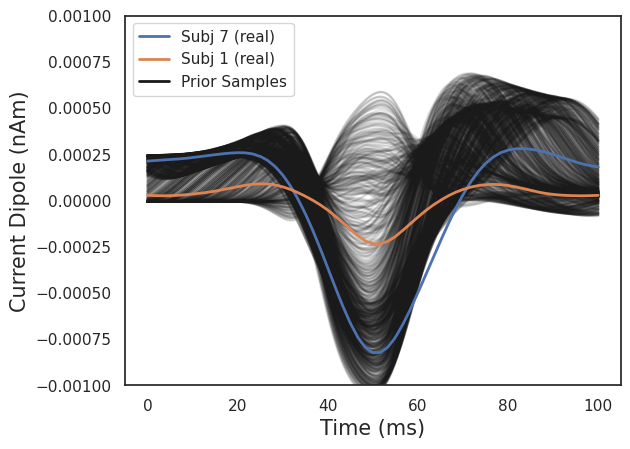

In [8]:
# subj_id_list = [9,1]
subj_id_list = [7,1]


_ = plt.plot(sim_times, x_orig[0:1000, :].T, color='k', alpha=0.1)
for subj_id in subj_id_list:
    _ = plt.plot(sim_times, empirical_beta_list[subj_id], label=f'Subj {subj_id} (real)', linewidth=2)



_ = plt.plot([0,0], [0,0], color='k', linewidth=2, label='Prior Samples')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Current Dipole (nAm)', fontsize=15)
plt.ylim(-0.001, 0.001)
plt.legend()

In [5]:
n_points = 50j
n_points_real = int(n_points.imag)
grid = torch.tensor(np.mgrid[0:1:n_points, 0:1:n_points].reshape(2, -1).T).float()
step_size = 1/n_points.imag

In [13]:
cond_list = [empirical_beta_list[subj_id] for subj_id in subj_id_list]
# 
# cond_list = [empirical_beta_large[0], empirical_beta_large[1]]

# Collect plotting data outside loop
scatter_data_list = list()
dist_data_list = list()
ppc_data_list = list()
theta_data_list = list()
prob_grid_dict = dict()

# input_type_list = ['pca30', 'pca4']
input_type_list = ['pca30']

for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])
    
    # Samples from posterior conditoned on grid sweep sims
    #x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    #x_val = x_val[:, window_samples[0]:window_samples[1]]

    #theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')


    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, df_sample_list, prob_grid_list = list(), list(), list()
    # cond_name = [f'subj_{subj_id}' for subj_id in subj_ids]
    cond_name_list = [f'subj{subj_id}' for subj_id in subj_id_list]
    for x_cond, cond_name in zip(cond_list, cond_name_list):
        load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                            'x_cond': posterior_dict['input_dict']['feature_func'](x_cond.reshape(1,-1))}
                     for name, posterior_dict in posterior_state_dicts.items()}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        df_sample_dict = {name: samples.numpy()[:, idx] for idx, name in enumerate(all_labels)}
        df_sample_dict['cond_name'] = np.repeat(cond_name, num_samples)
        df_sample_temp = pd.DataFrame(df_sample_dict)
        df_sample_list.append(df_sample_temp)

        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)
        df_temp = pd.DataFrame(df_dict)
        df_list.append(df_temp)
        
        log_prob_grid = posterior.log_prob(
            grid, x=load_info[input_type]['x_cond'].squeeze()).reshape(
            (n_points_real, n_points_real))
        prob_grid_list.append(np.exp(log_prob_grid.numpy()))
        
    df = pd.concat(df_list)
    df_sample = pd.concat(df_sample_list)
    
    scatter_data_list.append(df)
    prob_grid_dict[input_type] = prob_grid_list
        
    # Parameter recovery
    #dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    #dist_data_list.append(dist_array)


    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    #ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    #ppc_data_list.append(ppc_array)
    





Conditioning Feature: pca30
 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

pca30


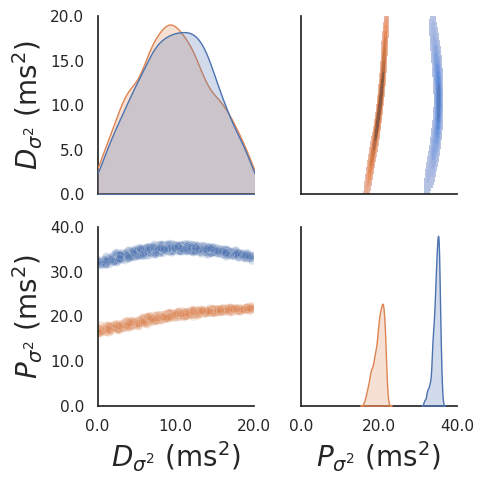

In [14]:
feature_idx = 0
print(input_type_list[feature_idx])

labelsize=20

param_labels = ['$D_{\sigma^2}$ ($\mathrm{ms}^2$)', '$P_{\sigma^2}$ ($\mathrm{ms}^2$)', '$D_e$ (log $\\bar{g}$)', '$P_e$ (log $\\bar{g}$)']

df = scatter_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(2):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

    
    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[1,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(2):
    for idx2 in range(2):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()

plt.savefig('hnn_beta_posterior_compare.svg')

In [15]:
%%capture
x_ppc_list, theta_ppc_list, net_ppc_list = list(), list(), list()
for cond in cond_name_list:
    df_filter = df_sample[df_sample['cond_name'] == cond][['dist_var', 'prox_var']]
    theta_cond_list = df_filter.values[:10,:]
    x_cond_list, theta_dict_list, net_list = list(), list(), list()
    for theta_cond in theta_cond_list:
        theta_dict = {param_name: theta_cond[idx] for 
                      idx, (param_name, param_dict) in enumerate(prior_dict.items())}

        x_cond = simulator(torch.tensor(theta_cond).float())
        x_cond = x_cond[:, window_samples[0]:window_samples[1]]

        theta_dict_list.append(theta_dict)
        x_cond_list.append(x_cond.numpy())
        net_list.append(net)
    
    x_ppc_list.append(x_cond_list)
    theta_ppc_list.append(theta_dict_list)
    net_ppc_list.append(net_list)

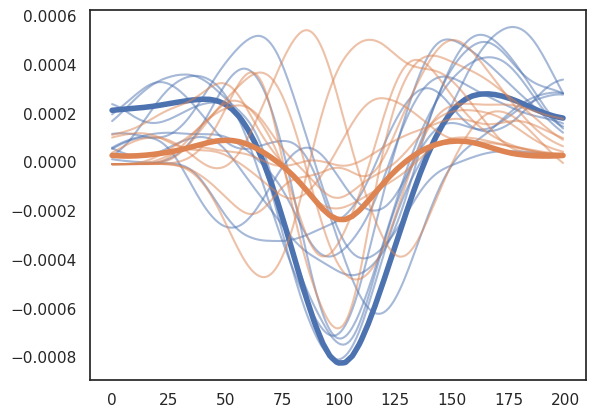

In [16]:
for idx, subj_id in enumerate(subj_id_list):
    _ = plt.plot(np.stack(x_ppc_list[idx]).squeeze().T, color=f'C{idx}', alpha=0.5)
    # _ = plt.plot(np.stack(x_ppc_list[idx]).squeeze().mean(axis=0), color=f'C{idx}', linewidth=6, linestyle='--')
    _ = plt.plot(empirical_beta_list[subj_id], color=f'C{idx}', linewidth=4)
    plt.plot()

In [23]:
x_large_val = np.stack(x_ppc_list[0]).squeeze()
x_small_val = np.stack(x_ppc_list[1]).squeeze()

/tmp/ipykernel_2555073/3078064052.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels((axes[0].get_xticks() - axes[0].get_xticks()[0]).astype(int))


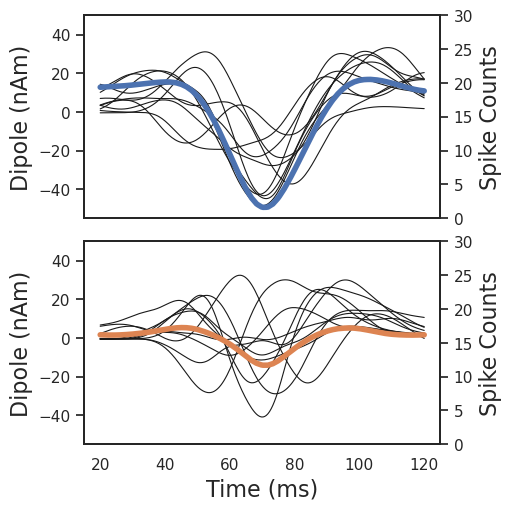

In [24]:
%matplotlib inline
bins = np.linspace(0,tstop,100)

labelsize = 16
titlesize=22

offset_samples = 0

waveform_ylim = [-55, 50]
hist_ylim = [0, 30]
# Plot conditioning features    
t_vec = np.linspace(0, tstop, cond_list[0].squeeze().shape[0])


fig, axes = plt.subplots(2,1,figsize=(5,5), constrained_layout=True, sharex=True)

# Top panel
axes[0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0].set_ylim(waveform_ylim)
ax_top_prox = axes[0].twinx()
ax_top_prox.set_ylim(hist_ylim)
ax_top_dist = axes[0].twinx()
ax_top_dist.set_ylim(hist_ylim)
ax_top_waveform = axes[0].twinx()
ax_top_waveform.set_ylim(waveform_ylim)
# ax_top_prox.hist(prox_times_list[0], color='C3', label='Proximal', bins=bins)
# ax_top_dist.hist(dist_times_list[0], color='C2', label='Distal', bins=bins)
ax_top_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_top_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_top_dist.set_yticklabels('')
ax_top_waveform.set_yticklabels('')
ax_top_dist.set_yticks([])
ax_top_waveform.set_yticks([])

_ = ax_top_waveform.plot(sim_times, x_large_val.T * scale_factor, linewidth=0.8, color='k', alpha=1.0)

ax_top_waveform.plot(sim_times, cond_list[0].squeeze() * scale_factor, linewidth=4, color='C0')
#axes[0].set_title('Condition 1', fontsize=titlesize)

# Bottom Panel
axes[1].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[1].set_ylim(waveform_ylim)
ax_bottom_prox = axes[1].twinx()
ax_bottom_prox.set_ylim(hist_ylim)
ax_bottom_dist = axes[1].twinx()
ax_bottom_dist.set_ylim(hist_ylim)
ax_bottom_waveform = axes[1].twinx()
ax_bottom_waveform.set_ylim(waveform_ylim)
# ax_bottom_prox.hist(prox_times_list[1], color='C3', label='Proximal', bins=bins)
# ax_bottom_dist.hist(dist_times_list[1], color='C2', label='Distal', bins=bins)
ax_bottom_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_bottom_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_bottom_dist.set_yticklabels('')
ax_bottom_waveform.set_yticklabels('')
ax_bottom_dist.set_yticks([])
ax_bottom_waveform.set_yticks([])

_ = ax_bottom_waveform.plot(sim_times, x_small_val.T * scale_factor, linewidth=0.8, color='k', alpha=1.0)
ax_bottom_waveform.plot(sim_times, cond_list[1].squeeze() * scale_factor, linewidth=4, color='C1')

axes[1].set_xlabel('Time (ms)', fontsize=labelsize)

# axes[0].set_xlim(time_lim)
axes[0].set_xticklabels((axes[0].get_xticks() - axes[0].get_xticks()[0]).astype(int))


plt.savefig('hnn_beta_cond_inputs.svg')

In [25]:
def psr(p1_points, p2_points, step_size, num_dim=1):
    points = np.vstack([p1_points, p2_points]).T
    min_points = np.min(points, axis=1)
    overlap_value = np.sum(min_points * (step_size ** num_dim))
    return overlap_value

def pir(p1_points, p2_points, step_size, num_dim=1):
    num_points = len(p1_points)
    sum_indices = np.array(list(itertools.permutations(range(num_points), 2)))

    left_product = p1_points[sum_indices[:,0]] * p2_points[sum_indices[:,1]]
    right_product = p1_points[sum_indices[:,1]] * p2_points[sum_indices[:,0]]
    
    points = np.vstack([left_product, right_product]).T
    min_points = np.min(points, axis=1)

    overlap_value = np.sum(min_points * (step_size ** (num_dim * 2)))
    
    return overlap_value

PSR: 0.9053718447685242, PIR: 0.8260777592658997
PSR: 3.192718421117663e-41, PIR: 0.0


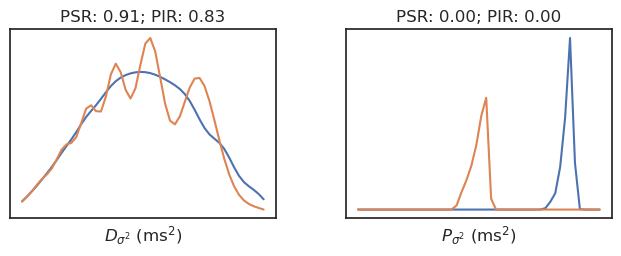

In [27]:
num_dim = 2
dim_set = set(range(num_dim))
input_type = 'pca30'
plt.figure()
for dim_idx in range(num_dim):
    marginal_dim = tuple(dim_set - {dim_idx})
    cond0_prob = np.sum(prob_grid_dict[input_type][0], axis=marginal_dim)
    cond1_prob = np.sum(prob_grid_dict[input_type][1], axis=marginal_dim)
    
    overlap_psr = psr(cond0_prob, cond1_prob, step_size, num_dim=num_dim)
    overlap_pir = pir(cond0_prob, cond1_prob, step_size, num_dim=num_dim)
    print(f'PSR: {overlap_psr}, PIR: {overlap_pir}')
    
    
    plt.subplot(2,2,dim_idx+1)
    plt.plot(cond0_prob)
    plt.plot(cond1_prob)
    
    plt.tight_layout()
    plt.title(f'PSR: {overlap_psr:.2f}; PIR: {overlap_pir:.2f}')
    plt.xlabel(f'{param_labels[dim_idx]}')
    plt.yticks([])
    plt.xticks([])
    